In [ ]:
import pylab as pp
import numpy as np
from scipy import integrate, interpolate
from scipy import optimize
from scipy.integrate import odeint

## Вариант 10
\begin{align}
y''(t)+2y'(t)+3y(t)=2u'(t)+4u(t)
\end{align}
\
\begin{align}
        A = \begin{pmatrix}
        0 & 1 \\
        -3 & -2
        \end{pmatrix}
\end{align}

\begin{align}
        B = \begin{pmatrix}
        0 \\ 1
        \end{pmatrix}
\end{align}

\begin{align}
        C = \begin{pmatrix}
        4 & 2
        \end{pmatrix}
\end{align}
\
\begin{align}
        \begin{cases}
        x_1'=x2\\
        x_2'=-3x_1-2x_2+u\\
        y=4x_1+2x_2
\end{cases}
    \end{align}

In [ ]:
# Сохраняем значения параметров и функцию в поля класса
# Исходными данными, передаваемыми при создании экземпляра класса оценки параметров являются:
# Функция f, реализующая вычисление ДУ
# Массив экспериментальных данных (x_data, y_data)
class parameter_estimator():
    def __init__(self, x_data, y_data, f, n_observed=None):
        self._x_data = x_data
        self._y_data = y_data
        self._f = f
        self._c = None
        self.n_observed = y_data.shape[1]

    def my_ls_func(self, x, teta):
        """
        Определение функции, возвращающей непосредственно решение системы ДУ
        в процессе оценки параметров
        x заданные (временные) точки, где известно решение
        (экспериментальные данные)
        teta -- массив с текущим значением оцениваемых параметров.
        Первые self._y0_len элементов -- начальные условия,
        остальные -- параметры ДУ
        """
        # Для передачи функуии используем ламбда-выражение с подставленными
        # параметрами
        # Вычислим значения дифференциального уравления в точках "x"
        r = integrate.odeint(lambda y, t: self._f(y, t, teta[self._y0_len:]),
                             teta[0:self._y0_len], x)
        # Возвращаем только наблюдаемые переменные
        return r[:, 0:self.n_observed]

    def f_resid(self, p):
        """
        Функция для передачи в optimize.leastsq
        Функция вычисляет вектор ошибок между решением системы ДУ
        с текущими значениями параметров и экспериментальными значениями.
        Функция получает вектор параметров системы (включая начальные условия ДУ).
        При дальнейших вычислениях значения, возвращаемые этой функцией,
        будут возведены в квадрат и просуммированы
        """
        delta = self._y_data -self.my_ls_func(self._x_data, p)
        return delta.flatten()  # Преобразуем в одномерный массив

    def estimate(self, y0, guess):
        """
        Произвести оценку параметров дифференциального уравнения с заданными
        начальными значениями параметров:
            y0 -- начальные условия ДУ
            guess -- начальные значения параметров системы ДУ
        """

        # Сохраняем число начальных условий
        self._y0_len = len(y0)

        # Создаем вектор оцениваемых параметров,
        # включающий в себя начальные условия
        self._est_values = np.concatenate((y0, guess))

        # Решаем оптимизационную задачу - решение в переменной c
        (c, kvg) = optimize.leastsq(self.f_resid, self._est_values)
        self._c = c
        # В возвращаемом значении разделяем начальные условия и параметры
        return c[self._y0_len:], c[0:self._y0_len]

    def calcODE(self, args, y0, x0=0, xEnd=10, nt=101):
        """
        Служебная функция для решения ДУ
        """
        t = np.linspace(x0, xEnd, nt)
        sol = odeint(self._f, y0, t, args)
        return sol, t

    def plot_result(self):
        """
        Строим графическое предстваление результутов оценки параметров
        """
        if self._c is None:
            print("Parameter is not estimated.")
            return

        sol, t = self.calcODE((self._c[self._y0_len:],),
                              self._c[0:self._y0_len],
                              min(self._x_data),
                              max(self._x_data))
        # Строим экспериментальные данные, как красные точки,
        # а результаты моделирования, как синюю линию
        pp.plot(self._x_data, self._y_data, '.r', t, sol, '-b')
        pp.xlabel('xlabel', {"fontsize": 16})
        pp.ylabel("ylabel", {"fontsize": 16})
        pp.legend(('data', 'fit'), loc=0)
        pp.show()

In [ ]:
def system_equations(y, t, k):
    x1, x2 = y
    a = k[0]
    b = k[1]
    # u(t) = 1 => u'(t) = 0
    dydt = [x2,-a*x1 - b*x2 + 1]
    return dydt

def calcSystem(args, y0, dy0, ts=10, nt=101):
  y0 = [y0, dy0]
  t = np.linspace(0, ts, nt)
  sol = odeint(system_equations, y0, t, args)
  return sol, t


# Зададим истинные значения параметров системы
a = 3
b = 2

args = ([a, b], )
y0 = 0
dy0 = 0
print("Real parameter: b = {}, c = {}".format(a, b))
print("Real initial condition: {} {}".format(y0, dy0))
sol, t = calcSystem(args, y0, dy0)

Real parameter: b = 3, c = 2
Real initial condition: 0 0


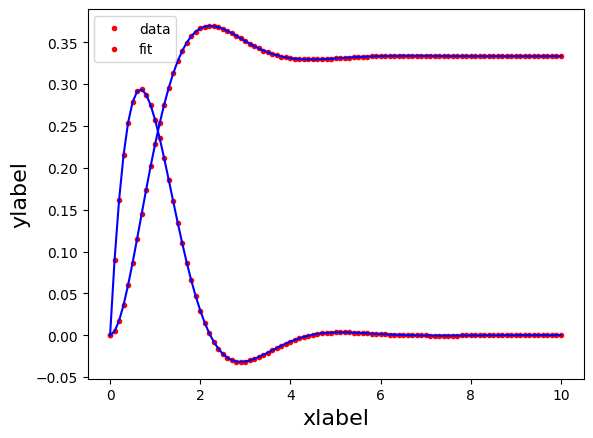

Estimated parameter: a=2.999999983750253, b=1.999999829927313
Estimated initial condition: [6.66271701e-08 3.65908249e-08]


In [ ]:
guess = [5, 1]  # Начальные значения для параметров системы
y0 = [0, 0]  # Стартовые начальные значения для системы ДУ

estimator = parameter_estimator(t, sol, system_equations)
est_par = estimator.estimate(y0, guess)
# Построим графики результатов оценки параметров
estimator.plot_result()
print("Estimated parameter: a={}, b={}".format(est_par[0][0], est_par[0][1]))
print("Estimated initial condition: {}".format(est_par[1]))